# Introduction

In this repository, we are going to learn how to construct a yield curve with 3 famous methods, that is Principal Component Analysis, Nelson-Siegel model and Nelson-Siegel-Svenson model. This model is based on *Computational Actuarial Science with R* by Arthur Charpentier.

In [1]:
import pandas as pd # Creating DataFrame
import numpy as np # Vector Matrices
import matplotlib.pyplot as plt # Plotting

# PCA

Principal Component Analysis (PCA) is a method to reduce dimensionality of a data without losing any significance information.

In [2]:
df = pd.read_csv('data/FedYieldCurve.csv', index_col = 'Unnamed: 0')
df

,R_3M,R_6M,R_1Y,R_2Y,R_3Y,R_5Y,R_7Y,R_10Y
1981-12-31,12.92,13.90,14.32,14.57,14.64,14.65,14.67,14.59
1982-01-31,14.28,14.81,14.73,14.82,14.73,14.54,14.46,14.43
1982-02-28,13.31,13.83,13.95,14.19,14.13,13.98,13.93,13.86
1982-03-31,13.34,13.87,13.98,14.20,14.18,14.00,13.94,13.87
1982-04-30,12.71,13.13,13.34,13.78,13.77,13.75,13.74,13.62
...,...,...,...,...,...,...,...,...
2012-07-31,0.10,0.14,0.18,0.27,0.37,0.71,1.14,1.68
2012-08-31,0.11,0.14,0.18,0.26,0.34,0.67,1.12,1.72
2012-09-30,0.10,0.15,0.18,0.28,0.37,0.71,1.15,1.75
2012-10-31,0.09,0.14,0.18,0.27,0.36,0.67,1.08,1.65


In [3]:
u, s, vh = np.linalg.svd((df-df.mean()).values)

In [4]:
yield_curve = pd.DataFrame(data = {'level': u[:,0]*s[0],
                                        'slope':u[:,1]*s[1],
                                        'curvature':u[:,2]*s[2]}, index = df.index)
yield_curve

,level,slope,curvature
1981-12-31,-24.841725,-0.096847,-0.077912
1982-01-31,-25.754093,1.238945,-0.645961
1982-02-28,-23.765354,0.845435,-0.386518
1982-03-31,-23.836928,0.865805,-0.381666
1982-04-30,-22.574645,0.374954,-0.311248
...,...,...,...
2012-07-31,13.949964,0.805307,0.060413
2012-08-31,13.969484,0.811951,0.021757
2012-09-30,13.916946,0.770492,0.032725
2012-10-31,14.001006,0.853652,0.081933


<AxesSubplot: title={'center': 'Level'}>

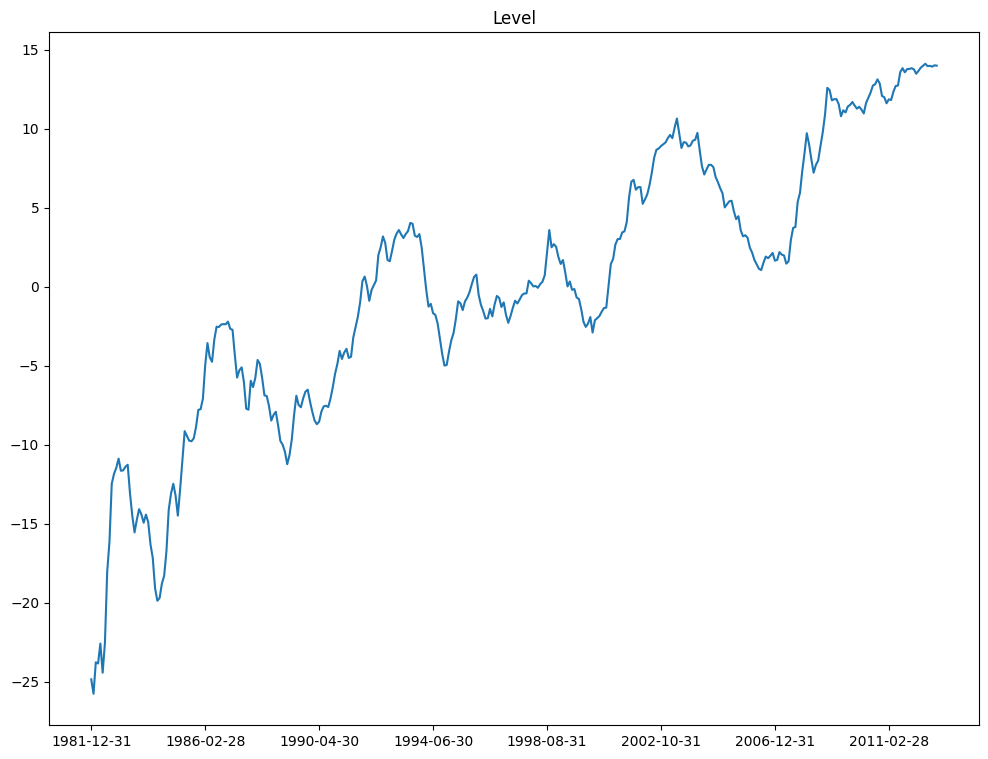

In [5]:
fig, ax = plt.subplots(figsize = (12,9))
plt.title('Level')
yield_curve.level.plot()

# Nelson - Siegel - Svennson Model

Let $s(t)$ be spot rate at time $t >0$. Nelson - Siegel - Svennson Model assumes taht the spot rates are governed by six paramaters according to the functional form:  
$$s(t, \tau) = \beta_0 + \beta_1 \left(\frac{1-\exp{\left(-\frac{\tau}{\lambda_1}\right)}}{\frac{\tau}{\lambda_1}}\right)+ \beta_2 \left(\frac{1-\exp{\left(-\frac{\tau}{\lambda_1}\right)}}{\frac{\tau}{\lambda_1}}-\exp{\left(-\frac{\tau}{\lambda_1}\right)} \right) + \beta_3 \left(\frac{1-\exp{\left(-\frac{\tau}{\lambda_2}\right)}}{\frac{\tau}{\lambda_2}}-\exp{\left(-\frac{\tau}{\lambda_2}\right)} \right)  $$ 
with $\tau$ is maturity of the bond

From equation above, we interest in estimating the set of parameter below: 
$$\mathbf{\beta} = \begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\ \beta_3 \\ \lambda_1 \\ \lambda_2\end{bmatrix}$$

And we interest in minimizing the equation below:  
$$\min_\mathbf{\beta} (y(t) - \hat{y}(t, \beta))^2$$ 
Two methods are being used, first is the Spiral Optimization (SPO), and Differential Evolution (DE). 

## Spiral Optimization

In [7]:
def nss(beta, tau):
    c1 = tau/beta[4] # tau / lambda 1
    c2 = tau/beta[5] # tau / lambda 2
    return beta[0] + beta[1]*((1-np.exp(-c1))/c1) + beta[2]*((1-np.exp(-c1))/c1 - np.exp(-c1)) + beta[3]*((1-np.exp(-c2))/c2 - np.exp(-c2))

In [8]:
def spo(y, mat, index, max_iter = 1000, theta = np.pi/4, m = 10):
    # Initial Guess
    tau = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
    cols = y.columns
    beta = np.random.rand(m,6)
    error = (y[cols[mat]][index] - nss(beta= beta, tau = tau[mat] ))**2
    beta_star = beta[np.argmin(error)]
    min_error = error[np.argmin(error)]
    r = 0.05
    
    # Rotation Matrix
    theta = np.pi/4
    n = 6
    rot_matrix = np.eye(n)
    rot_matrix[n-2,n-2] = np.cos(theta)
    rot_matrix[n-2, n-1] = -np.sin(theta)
    rot_matrix[n-1, n-2] = np.sin(theta)
    rot_matrix[n-1, n-1] = np.cos(theta)

    for i in range(n-3, -1, -1):
        for j in range(n-1,i,-1):
            r_n = np.eye(n)
            r_n[n-i-2,n-j-2] = np.cos(theta)
            r_n[n-i-2,n-j-1] = -np.sin(theta)
            r_n[n-i-1,n-j-2] = np.sin(theta)
            r_n[n-i-1,n-j-1] = np.cos(theta)
            rot_matrix = rot_matrix.dot(r_n)

    # Update Algorithm 
    for n in range(10000):
        r = 0.05
    new_error = (y[cols[mat]][index] - nss(beta = beta, tau = tau[mat] ))**2
    if min_error > new_error[np.argmin(new_error)]:
        min_error = new_error[np.argmin(new_error)]
        beta_star = beta[np.argmin(new_error)]    
    
    # Update beta and beta star        
    for i in range(beta.shape[0]):
        beta[i] = beta_star + r*rot_matrix.dot(beta[i] - beta_star)
    for n in range(max_iter):
        new_error = (y[cols[mat]][index] - nss(beta = beta, tau = tau[mat] ))**2
        
        if min_error > new_error[np.argmin(new_error)]:
            min_error = new_error[np.argmin(new_error)]
            beta_star = beta[np.argmin(new_error)]    
        
        # Update beta and beta star        
        for i in range(beta.shape[0]):
            beta[i] = beta_star + r*rot_matrix.dot(beta[i] - beta_star)
            
    return beta_star, min_error

In [26]:
error = []
params = []
for n in range(5):
    paramss, err = spo(y = df, mat = 2, index =-1 , max_iter= 10000)
    params.append(paramss)
    error.append(err)

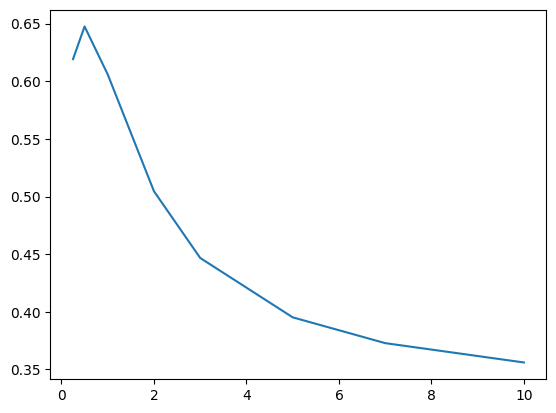

In [31]:
plt.plot([0.25, 0.5, 1, 2, 3, 5, 7, 10], nss(beta = params[0], tau = [0.25, 0.5, 1, 2, 3, 5, 7, 10]))
plt.show()

In [32]:
nss(beta=params[0], tau = [0.25, 0.5, 1, 2, 3, 5, 7, 10])

array([0.61918515, 0.64750928, 0.6059561 , 0.50460759, 0.44672621,
       0.39522351, 0.37285153, 0.35606806])

In [33]:
df.iloc[-1]

R_3M     0.07
R_6M     0.12
R_1Y     0.16
R_2Y     0.26
R_3Y     0.35
R_5Y     0.70
R_7Y     1.13
R_10Y    1.72
Name: 2012-11-30, dtype: float64

In [29]:
params

[array([0.3169065 , 0.10467972, 0.72486651, 0.26073285, 0.42455337,
        0.15122341]),
 array([0.60167207, 0.25462362, 0.69404612, 0.19308947, 0.92641674,
        0.394042  ]),
 array([0.23676318, 0.29344185, 0.69379651, 0.05625983, 0.64166585,
        0.94528137]),
 array([0.28034933, 0.90458826, 0.21242703, 0.50403873, 0.95055135,
        0.21070744]),
 array([0.89981495, 0.84328157, 0.99046174, 0.15682297, 0.03271318,
        0.22152524])]

In [30]:
error

[1.5241626032613036e-05,
 0.001771028033276888,
 0.00888205675343834,
 0.0044724333306282865,
 0.0010677602798225578]